In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ucimlrepo import fetch_ucirepo

In [8]:
# preprocessing

diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

columns_to_drop = ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']

# drop features: weight, payer_code, medical_specialty, max_glu_serum, A1Cresult
X = X.drop(columns=columns_to_drop)
X.drop(X[X['gender'] == 'Unknown/Invalid'].index, inplace=True)
# results in 105 column features after transform

# labels = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury',
#           'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Other']
def map_icd_to_category(icd_code):
    try:
        icd_code = float(icd_code)
    except ValueError:
        return "Other"
    if 390 <= icd_code <= 459 or icd_code == 785:
        return 'Circulatory'
    elif 460 <= icd_code <= 519 or icd_code == 786:
        return 'Respiratory'
    elif 520 <= icd_code <= 579 or icd_code == 787:
        return 'Digestive'
    elif str(icd_code).startswith('250'):
        return 'Diabetes'
    elif 800 <= icd_code <= 999:
        return 'Injury'
    # Musculoskeletal
    elif 710 <= icd_code <= 739:
        return 'Musculoskeletal'
    # Genitourinary
    elif 580 <= icd_code <= 629 or icd_code == 788:
        return 'Genitourinary'
    # Neoplasms
    elif 140 <= icd_code <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

X['diag_1'] = X['diag_1'].apply(map_icd_to_category)
X['diag_2'] = X['diag_2'].apply(map_icd_to_category)
X['diag_3'] = X['diag_3'].apply(map_icd_to_category)

categorical_columns = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
X_encoded = encoder.fit_transform(X[categorical_columns])
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_encoded = pd.concat([X_encoded, X.drop(columns=categorical_columns)], axis=1)

column_variances = X_encoded.var()
nzv = set()
# set of near zero variance features
for column, variance in column_variances.items():
    if variance < .001:
        nzv.add(column.split('_')[0])

columns_to_drop = []
for column in X_encoded.columns:
    parts = column.split('_')
    if parts[0] in nzv:
        columns_to_drop.append(column)

X_encoded = X_encoded.drop(columns=columns_to_drop)

missing_values = X_encoded.isnull().any(axis=1)
X_encoded = X_encoded[~missing_values]
y = y[~missing_values]

y['readmitted'] = y['readmitted'].map({'<30': 1, '>30': 1, 'NO': 0})

# pd.set_option('display.max_columns', None)
# print(X_encoded.head(1000))


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\loren\AppData\Local\Temp\ipykernel_24216\2282709862.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['readmitted'] = y['readmitted'].map({'<30': 1, '>30': 1, 'NO': 0})


In [3]:
# logistic_classifier cross validation
import timeit

train_accuracies = []
test_accuracies = []
conf_matrices = []
models = dict()

cs = [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for c in cs:
    if c == 0:
        classifier = LogisticRegression(penalty=None, max_iter=1000, fit_intercept=True)
    else:
        classifier = LogisticRegression(penalty='l2', C=c, max_iter=2000, solver='sag', fit_intercept=True)
    classifier.fit(X_train, y_train.values.ravel())
    train_accuracies.append(classifier.score(X_train, y_train))
    test_accuracies.append(classifier.score(X_val, y_val))
    conf_matrices.append(confusion_matrix(y_val, classifier.predict(X_val)))
    print(f"Concluded training with C={c}")
    models[c] = classifier

c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Concluded training with C=0
Concluded training with C=0.0001
Concluded training with C=0.001
Concluded training with C=0.01


c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Concluded training with C=0.1


c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Concluded training with C=1.0


c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Concluded training with C=10.0
Concluded training with C=100.0


c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [4]:
# Logistic Classifier Prediction speed
prediction_speeds = dict()
print(len(models))
for c in cs:
    model = models[c]
    # get prediction speed for entire validation set 1000 times, average
    pred = []
    for i in range(1000):    
        start = timeit.default_timer()
        models[10].predict(X_val)
        end = timeit.default_timer()
        pred.append((end - start)/len(X_val))
    prediction_speeds[c] = (sum(pred)/len(pred))
    print(f"Avg Prediction speed for C={c}: {(sum(pred)/len(pred))} seconds")
print(len(prediction_speeds))

8
Avg Prediction speed for C=0: 1.4580829196771616e-07 seconds
Avg Prediction speed for C=0.0001: 1.4292154789432882e-07 seconds
Avg Prediction speed for C=0.001: 1.4221849960335162e-07 seconds
Avg Prediction speed for C=0.01: 1.4596738445835366e-07 seconds
Avg Prediction speed for C=0.1: 1.4571684960647767e-07 seconds
Avg Prediction speed for C=1.0: 1.5531055726366567e-07 seconds
Avg Prediction speed for C=10.0: 1.5459824512761455e-07 seconds
Avg Prediction speed for C=100.0: 1.555992798877673e-07 seconds
8


In [5]:
# Logistic Classifier collect accuracy, precision, recall, and roc_auc scores
accuracies = dict()
precisions = dict()
recalls = dict()
roc_aucs = dict()
for c in cs:
    y_pred = models[c].predict(X_val)
    accuracies[c]=accuracy_score(y_val, y_pred)
    precisions[c]=precision_score(y_val, y_pred)
    recalls[c]=recall_score(y_val, y_pred)
    roc_aucs[c]=roc_auc_score(y_val, y_pred)


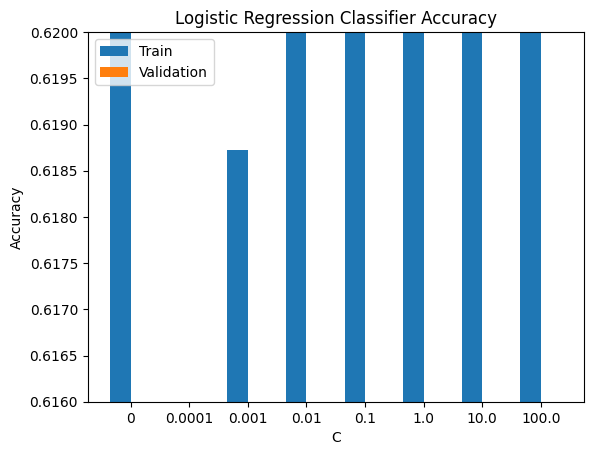

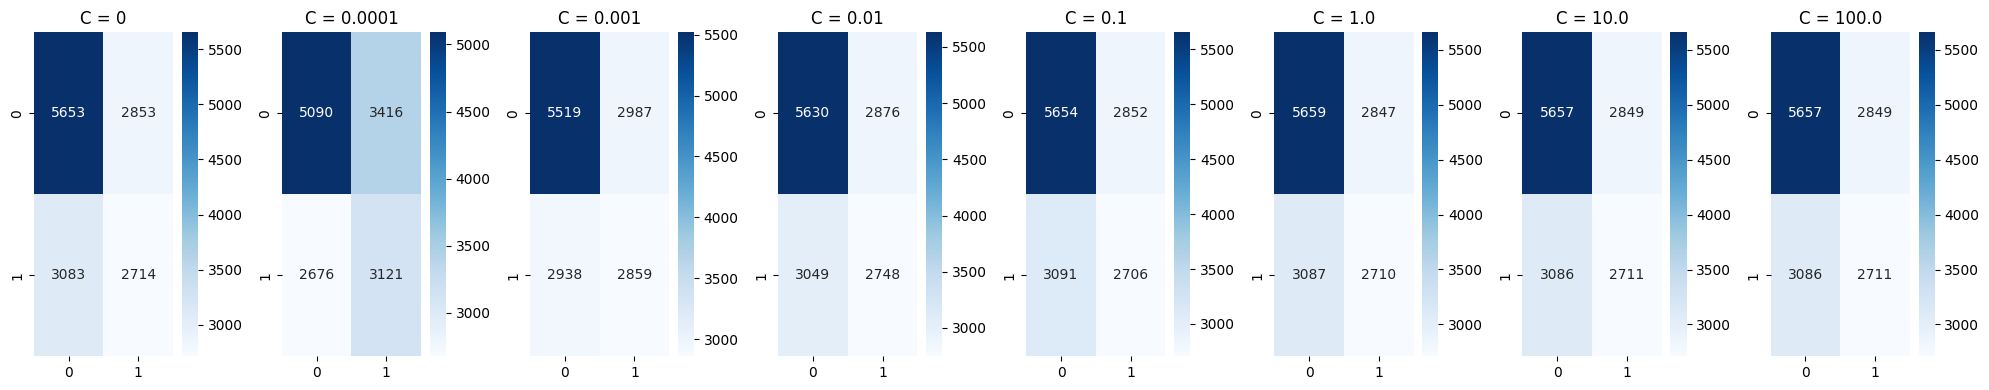

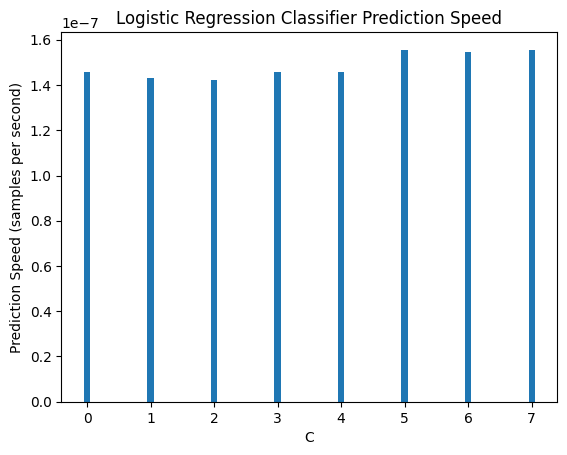

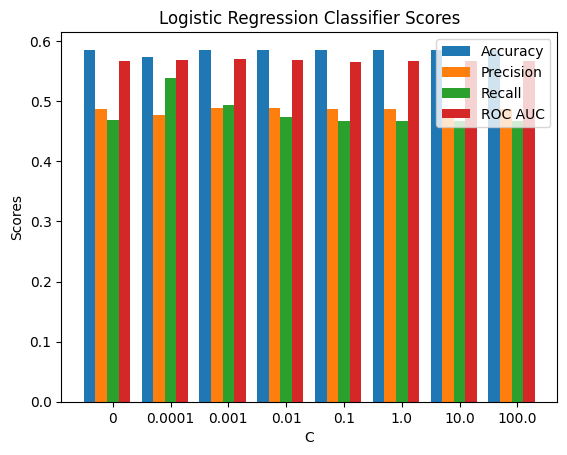

Model statistics
Accuracy:  0.5850520869747605
Precision:  0.48758992805755397
Recall:  0.46765568397446955
ROC AUC:  0.5663578208257019
Prediction speed:  1.5459824512761455e-07
{0: 1.4580829196771616e-07, 0.0001: 1.4292154789432882e-07, 0.001: 1.4221849960335162e-07, 0.01: 1.4596738445835366e-07, 0.1: 1.4571684960647767e-07, 1.0: 1.5531055726366567e-07, 10.0: 1.5459824512761455e-07, 100.0: 1.555992798877673e-07}


In [6]:
# logistic regression classifier plotting

# plot accuracies from dictionary
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(cs))
train_bars = ax.bar(index, train_accuracies, bar_width, label='Train')
test_bars = ax.bar(index + bar_width, test_accuracies, bar_width, label='Validation')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression Classifier Accuracy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cs)
ax.set_ylim(0.616, 0.62)
ax.legend()
plt.show()

# plot confusion matrix
fig, axes = plt.subplots(1, 8, figsize=(20, 4))
for i, conf_matrix in enumerate(conf_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'C = {cs[i]}')
    
plt.tight_layout()
plt.show()

# plot prediction speed
fig, ax = plt.subplots()
bar_width = 0.1
index = np.arange(len(cs))
speed_bars = ax.bar(index, prediction_speeds.values(), bar_width)

ax.set_xlabel('C')
ax.set_ylabel('Prediction Speed (samples per second)')
ax.set_title('Logistic Regression Classifier Prediction Speed')
plt.show()

# plot accuracy, precision, recall, and roc_auc scores
fig, ax = plt.subplots()
bar_width = 0.2
index = np.arange(len(cs))
accuracy_bars = ax.bar(index, accuracies.values(), bar_width, label='Accuracy')
precision_bars = ax.bar(index + bar_width, precisions.values(), bar_width, label='Precision')
recall_bars = ax.bar(index + 2 * bar_width, recalls.values(), bar_width, label='Recall')
roc_auc_bars = ax.bar(index + 3 * bar_width, roc_aucs.values(), bar_width, label='ROC AUC')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
ax.set_title('Logistic Regression Classifier Scores')
ax.set_xticks(index + 2 * bar_width)
ax.set_xticklabels(cs)
ax.legend()
plt.show()



# print the statistics of best model (c=10)
print("Model statistics")
print("Accuracy: ", accuracies[10])
print("Precision: ", precisions[10])
print("Recall: ", recalls[10])
print("ROC AUC: ", roc_aucs[10])
print("Prediction speed: ", prediction_speeds[10])
print(prediction_speeds)

